In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input/train_identity.csv
./input/sample_submission.csv
./input/test_transaction.csv
./input/train_transaction.csv
./input/test_identity.csv


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./output'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./output/test_transaction_update_1.pkl
./output/test_transaction_update.pkl
./output/train_transaction_update_1.pkl
./output/train_transaction_update.pkl
./output/last_transaction.pkl
./output/transaction_identity.pkl
./output/Groups.pkl


In [3]:
import matplotlib.pyplot as plt
import datetime
import decimal
import seaborn as sns
import warnings 
import gc,os,random
from decimal import *
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
warnings.filterwarnings(action='ignore')
%matplotlib inline
pd.options.display.max_rows=500
pd.options.display.max_columns=100
pd.options.display.max_colwidth=100
gc.enable()
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics

In [4]:
train = pd.read_pickle('./output/train_transaction_update_1.pkl')
test = pd.read_pickle('./output/test_transaction_update_1.pkl')
nrows= train.shape[0]

In [6]:
train.shape,test.shape

((590540, 975), (506691, 975))

In [7]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics and col not in ['TransactionAmt','TransactionDateTime','First_TransactionDay']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    
    
    
SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'

In [8]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1462.02 Mb (66.6% reduction)
Mem. usage decreased to 1265.07 Mb (66.4% reduction)


In [12]:
col_remove = ['uid','uid2','uid3','uid4','uid5','uid6','uid7','uid10','uid11','uid12','First_TransactionDay','bank_type','TransactionDateTime','TransactionID'\
              ,'isFraud','product_type','product_type2','D1_clone','TransactionDT','card123456','device_hash']
cols_to_use = [i for i in train.columns if i not in col_remove]

In [13]:
len(cols_to_use)

957

In [15]:
for col in list(train.columns):
    if train[col].dtype=='O':
        train[col] = train[col].fillna('unseen_before_label')
        test[col] = test[col].fillna('unseen_before_label')

        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)

        le = LabelEncoder()
        le.fit(list(train[col])+list(test[col]))
        train[col] = le.transform(train[col])
        test[col]  = le.transform(test[col])

        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')


In [16]:
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [17]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt']) 

In [18]:
train['TransactionAmt_decimal'] = np.round(train['TransactionAmt'] - np.floor(train['TransactionAmt']),2)
test['TransactionAmt_decimal'] = np.round(test['TransactionAmt'] - np.floor(test['TransactionAmt']),2 )

In [19]:
train.select_dtypes(include='category').columns

Index(['uid', 'uid2', 'uid3', 'uid4', 'uid5', 'uid6', 'uid7', 'product_type',
       'uid10', 'uid11', 'DeviceInfo'],
      dtype='object')

In [20]:
test.select_dtypes(include='category').columns

Index(['uid', 'uid4', 'First_TransactionDay', 'device_hash'], dtype='object')

In [21]:
cols = ['uid', 'uid2', 'uid3', 'uid4', 'uid5', 'uid6', 'uid7', 'product_type',
       'uid10', 'uid11', 'DeviceInfo','First_TransactionDay','device_hash']

In [22]:
train[cols] = train[cols].astype('category')
test[cols] = test[cols].astype('category')

In [23]:
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':20000,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [25]:
target = train['isFraud']
folds = GroupKFold(n_splits=6)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(tqdm(folds.split(train.values, target.values,train['TransactionDateTime_month']))):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][cols_to_use], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][cols_to_use][cols_to_use], label=target.iloc[val_idx])
    num_round = 20000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][cols_to_use], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    
        
    fold_importance_df["Feature"] = cols_to_use
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[cols_to_use], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.999009	valid_1's auc: 0.928689
[1000]	training's auc: 0.999961	valid_1's auc: 0.93654
Early stopping, best iteration is:
[1310]	training's auc: 0.999972	valid_1's auc: 0.938241
Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.999002	valid_1's auc: 0.957506
[1000]	training's auc: 0.999992	valid_1's auc: 0.960228
Early stopping, best iteration is:
[1074]	training's auc: 0.999997	valid_1's auc: 0.960375
Fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.998907	valid_1's auc: 0.955303
[1000]	training's auc: 0.99999	valid_1's auc: 0.959419
Early stopping, best iteration is:
[986]	training's auc: 0.999988	valid_1's auc: 0.959482
Fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.99884	valid_1's auc: 0.951212
[1000]	training's auc: 0.999988	valid_1's auc: 0.955744
Early s

In [ ]:
score = metrics.roc_auc_score(target, oof)
score =  round(score,4)

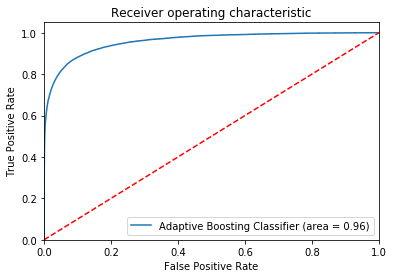

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(train['isFraud'], oof)
fpr, tpr, thresholds = roc_curve(train['isFraud'], oof)
plt.figure()
plt.plot(fpr, tpr, label='Adaptive Boosting Classifier (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [29]:
now = datetime.datetime.now()
now = str(now.strftime('%Y-%m-%d-%H-%M-%S'))
print('started at:', now)
print(train.shape,test.shape)

started at: 2019-10-02-01-49-52
(590540, 975) (506691, 975)


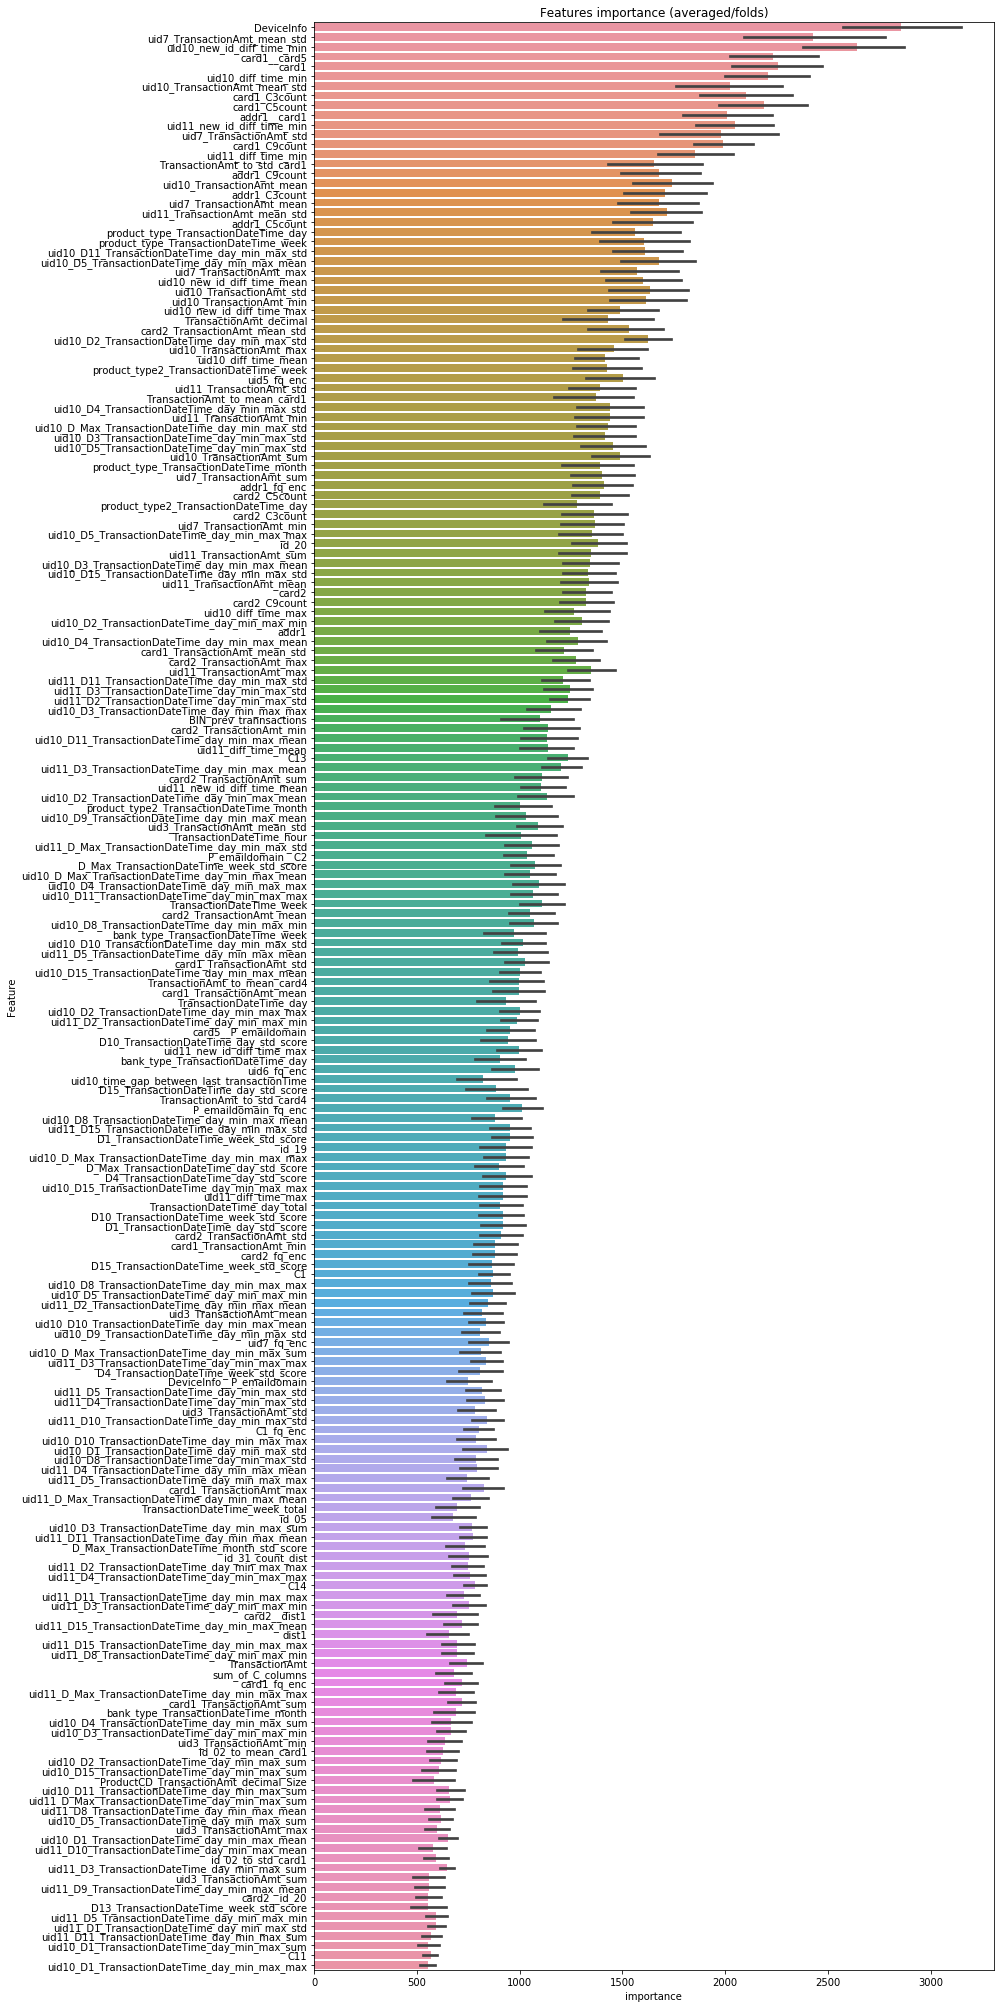

In [30]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig(f'./submissions/IEEE_MODEL_2-Copy1{now}_{score}.png')

In [31]:
sub_df = pd.DataFrame(test[["TransactionID"]])
sub_df['isFraud'] = predictions 
sub_df.to_csv(f"./submissions/IEEE_MODEL_2-Copy1_{now}_{score}.csv", index=False)

In [32]:
feature_importance_df.to_csv(f"./submissions/Fature_importance_IEEE_MODEL_2-Copy1_{now}_{score}.csv")

In [40]:
from IPython.display import FileLink, FileLinks
FileLinks('./submissions/')

./submissions/
  IEEE_MODEL_2_2019-09-24-09-25-37_0.9578.csv
  IEEE_MODEL_2_2019-09-24-15-39-30_0.9993.png
  IEEE_MODEL_2-Copy1_2019-10-01-21-58-59_0.9579.csv
  IEEE_MODEL_2-Copy12019-10-02-01-49-52_0.958.png
  IEEE_MODEL_2_2019-09-24-15-41-32_0.9993.csv
  Fature_importance_2019-09-25-22-49-21_0.9579602005610313.csv
  IEEE_MODEL_2_2019-09-25-22-49-21_0.9579602005610313.png
  IEEE_MODEL_2_2019-09-24-15-41-32_0.9993.png
  IEEE_MODEL_2-Copy12019-10-01-21-58-59_0.9579.png
  IEEE_MODEL_2-Copy1_2019-10-02-01-49-52_0.958.csv
  IEEE_MODEL_2_2019-09-24-11-52-03_1.0.png
  IEEE_MODEL_2_2019-09-26-23-06-07_0.9577.csv
  IEEE_MODEL_2_2019-09-24-12-34-14_0.9997.csv
  Fature_importance_IEEE_MODEL_2-Copy1_2019-10-01-21-58-59_0.9579.csv
  Fature_importance_2019-09-24-09-25-37_0.9578.csv
  IEEE_MODEL_2_2019-09-24-14-54-16_0.5339.png
  Fature_importance_2019-09-26-23-06-07_0.9577.csv
  IEEE_MODEL_2_2019-09-24-12-34-14_0.9997.png
  IEEE_MODEL_2_2019-09-26-23-06-07_0.9577.png
  IEEE_MODEL_2_2019-09-24-15-39-30_0.9993.csv
  Fature_importance_2019-09-24-12-34-14_0.9997.csv
  Fature_importance_2019-09-24-14-54-16_0.5339.csv
  IEEE_MODEL_2_2019-09-24-14-54-16_0.5339.csv
  Fature_importance_IEEE_MODEL_2-Copy1_2019-10-02-01-49-52_0.958.csv
  Fature_importance_2019-09-24-15-39-30_0.9993.csv
  IEEE_MODEL_2_2019-09-25-22-49-21_0.9579602005610313.csv
  IEEE_MODEL_2_2019-09-24-11-52-03_1.0.csv
  merge_923_magic2_merge9592.csv
  Fature_importance_2019-09-24-11-52-03_1.0.csv
  IEEE_MODEL_2_2019-09-24-09-25-37_0.9578.png